In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize

In [95]:
nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [96]:
train = pd.read_csv("train.csv")

test = pd.read_csv("test.csv")

In [97]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [98]:
train.shape, test.shape, test.shape[0]/train.shape[0]

((7613, 5), (3263, 4), 0.4286089583606988)

In [99]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))

print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))


There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [101]:
null_counts = pd.DataFrame({"Num_Null": train.isnull().sum()})

null_counts["Pct_Null"] = null_counts["Num_Null"] / train.count() * 100

null_counts

,Num_Null,Pct_Null
id,0,0.000000
keyword,61,0.807733
location,2533,49.862205
text,0,0.000000
target,0,0.000000


<b>EXPLORATORY DATA ANALYSIS

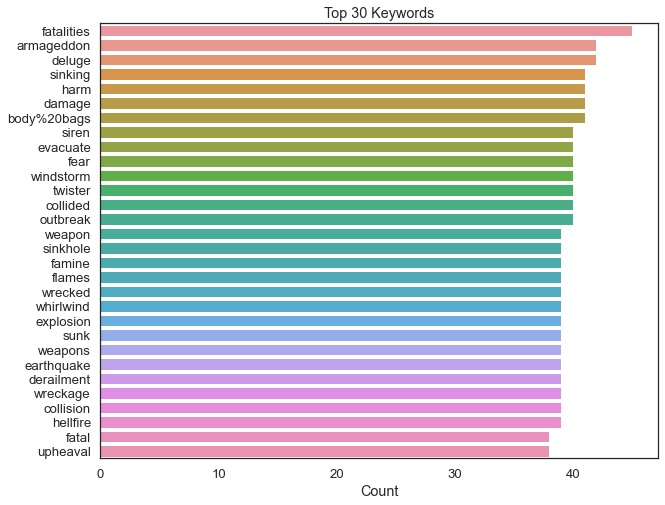

In [133]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})

sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')

plt.title("Top 30 Keywords")

plt.show()

In [103]:
len(train["keyword"].value_counts())

221

In [104]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()

nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()



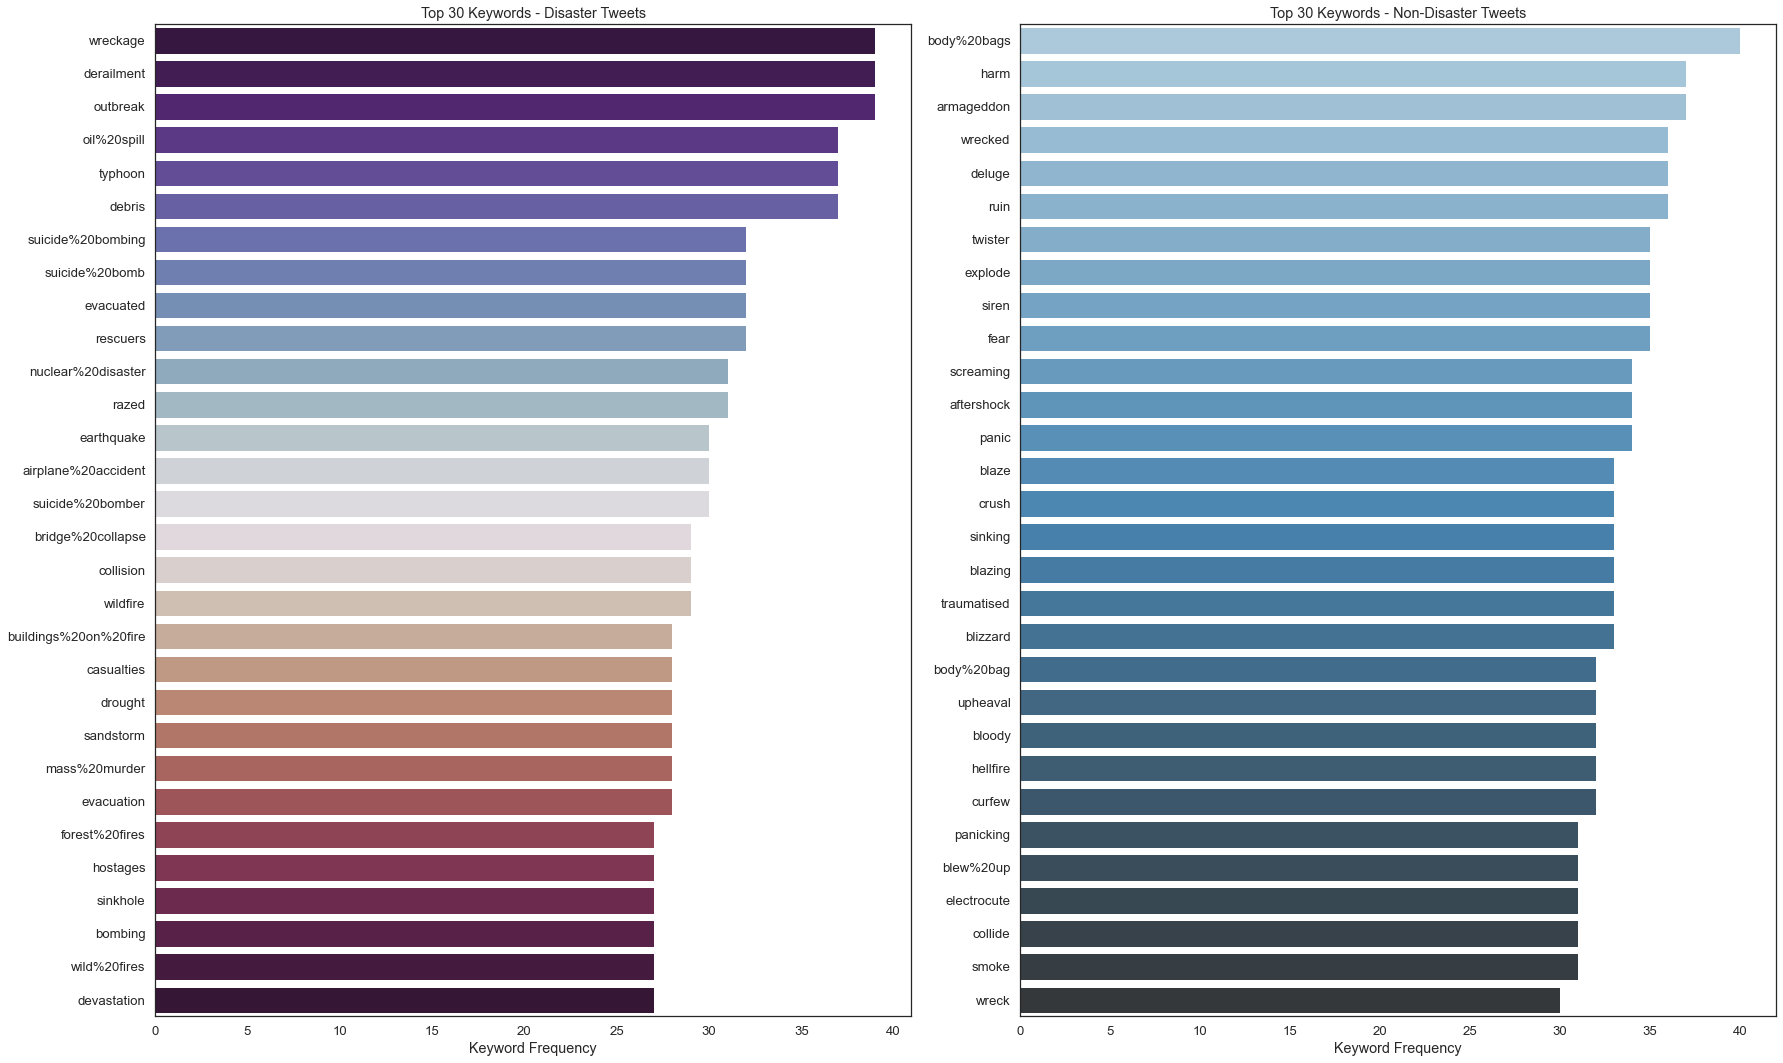

In [105]:
fig, ax = plt.subplots(1,2, figsize=(25,15))

sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="twilight_shifted")

sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")

ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

In [106]:
armageddon_tweets = train[(train["keyword"].fillna("").str.contains("armageddon")) & (train["target"] == 0)]

print("An example tweet:\n", armageddon_tweets.iloc[10, 3])

armageddon_tweets.head()

An example tweet:
 @ENews Ben Affleck......I know there's a wife/kids and other girls but I can't help it. I've loved him since Armageddon #eonlinechat


,id,keyword,location,text,target
304,446,armageddon,"California, United States",#PBBan (Temporary:300) avYsss @'aRmageddon | D...,0
305,447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...,0
306,448,armageddon,#FLIGHTCITY UK,((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...,0
307,450,armageddon,NaN,ouvindo Peace Love &amp; Armageddon,0
308,451,armageddon,NaN,Best movie you've ever seen? - Armageddon htt...,0


In [107]:
def keyword_disaster_probabilities(x):
    tweets_w_keyword = np.sum(train["keyword"].fillna("").str.contains(x))
    tweets_w_keyword_disaster = np.sum(train["keyword"].fillna("").str.contains(x) & train["target"] == 1)
    return tweets_w_keyword_disaster / tweets_w_keyword

keywords_vc["Disaster_Probability"] = keywords_vc.index.map(keyword_disaster_probabilities)
keywords_vc.head()

,Count,Disaster_Probability
fatalities,45,0.577778
armageddon,42,0.119048
deluge,42,0.188406
sinking,41,0.195122
harm,41,0.097561


In [108]:

keywords_vc.sort_values(by="Disaster_Probability", ascending=False).head(10)

,Count,Disaster_Probability
wreckage,39,1.000000
debris,37,1.000000
derailment,39,1.000000
outbreak,40,0.975000
typhoon,38,0.973684
oil%20spill,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.951613
suicide%20bomb,35,0.949495


In [109]:
keywords_vc.sort_values(by="Disaster_Probability").head(10)

,Count,Disaster_Probability
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
screaming,36,0.055556
traumatised,35,0.057143
panicking,33,0.060606
blew%20up,33,0.060606
blight,32,0.062500
body%20bag,33,0.065421


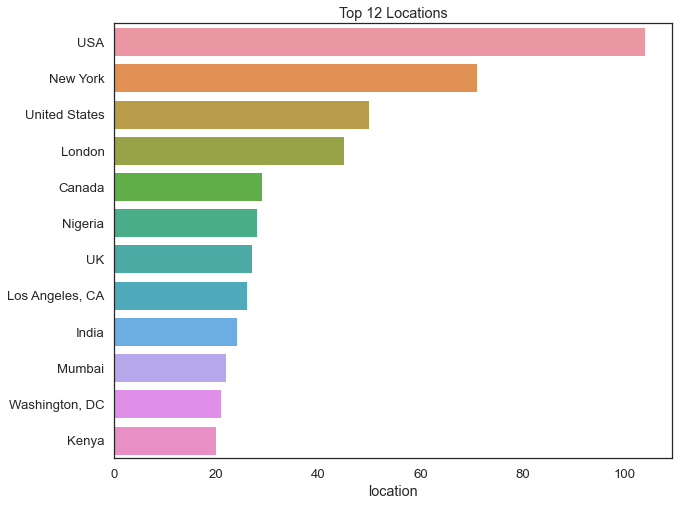

In [139]:
locations_vc = train["location"].value_counts()
sns.barplot(y=locations_vc[0:12].index, x=locations_vc[0:12], orient='h')
plt.title("Top 12 Locations")
plt.show()

In [19]:
len(train["location"].value_counts())

3341

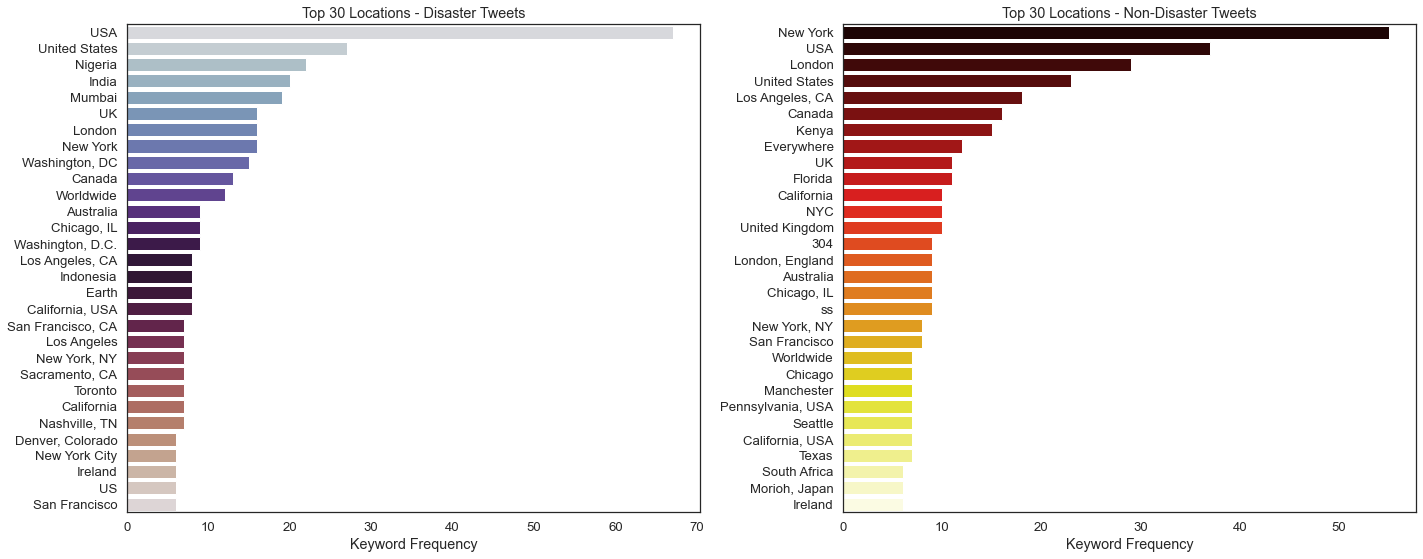

In [114]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()

nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()



fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="twilight")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="hot")

ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

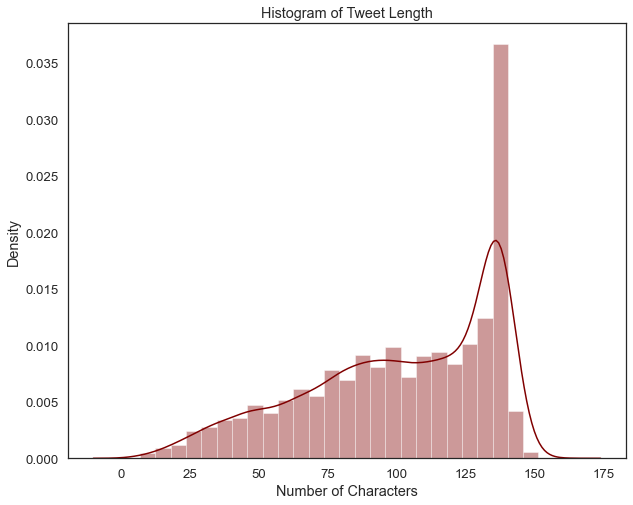

In [115]:
train["tweet_length"] = train["text"].apply(len)

sns.distplot(train["tweet_length"] ,color = "maroon")
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

In [22]:
min(train["tweet_length"]), max(train["tweet_length"])

(7, 157)

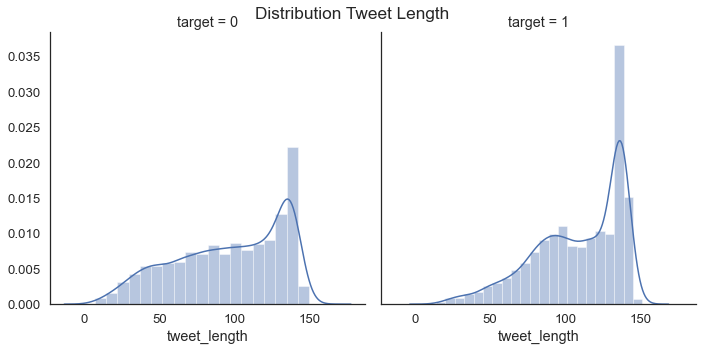

In [122]:
dist_length = sns.FacetGrid(train, col="target", height=5 )
dist_length = dist_length.map(sns.distplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

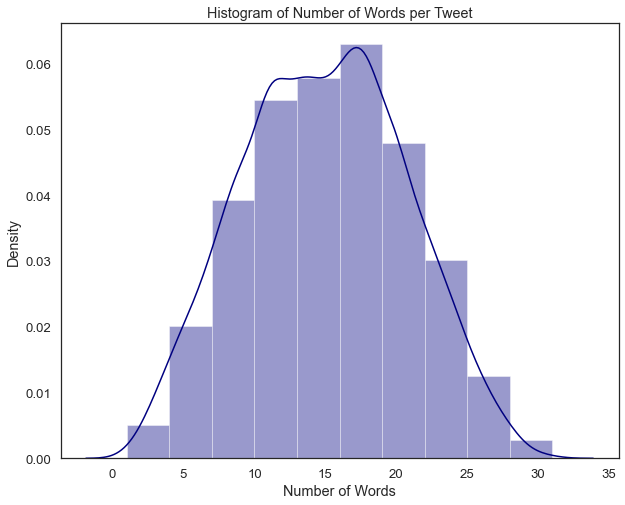

In [123]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)

sns.distplot(train["num_words"], bins=10 ,color = "navy")
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

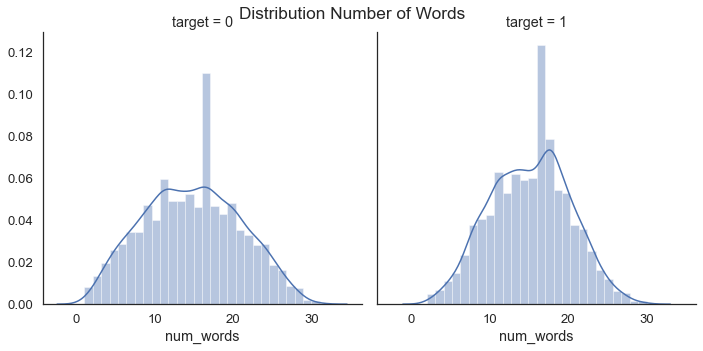

In [128]:
dist_num_of_words = sns.FacetGrid(train, col="target", height=5 )
dist_num_of_words = dist_num_of_words.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

/Users/ajhvrry/Downloads/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


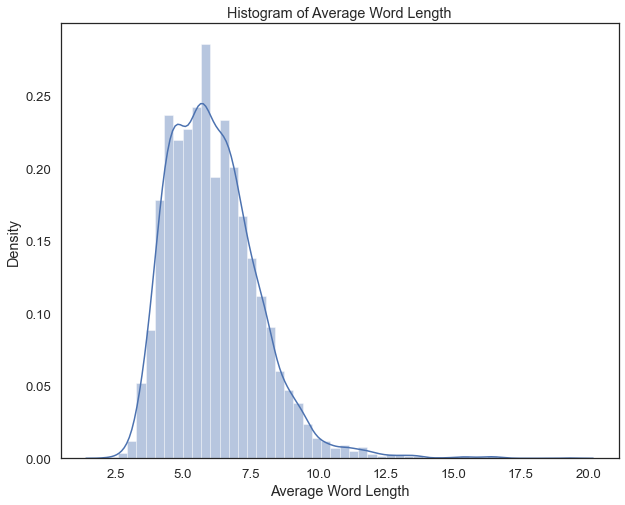

In [26]:
def avg_word_length(x):
    return np.sum([len(w) for w in x.split()]) / len(x.split())

train["avg_word_length"] = train["text"].apply(avg_word_length)
sns.distplot(train["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

/Users/ajhvrry/Downloads/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajhvrry/Downloads/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


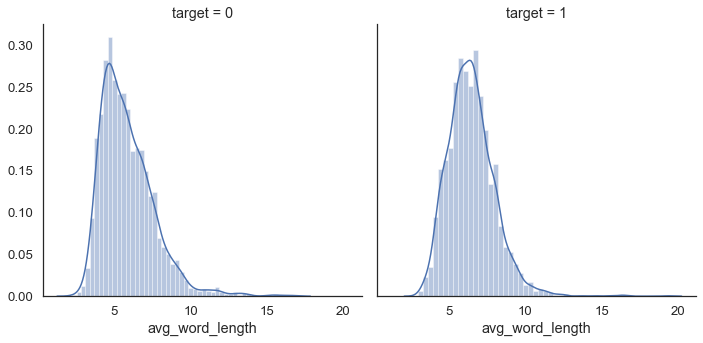

In [27]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "avg_word_length")

# Common Stopwords

In [28]:
def create_corpus(target):
    corpus = []

    for w in train.loc[train["target"] == target]["text"].str.split():
        for i in w:
            corpus.append(i)
            
    return corpus

def create_corpus_dict(target):
    corpus = create_corpus(target)
            
    stop_dict = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            stop_dict[word] += 1
    return sorted(stop_dict.items(), key=lambda x:x[1], reverse=True)

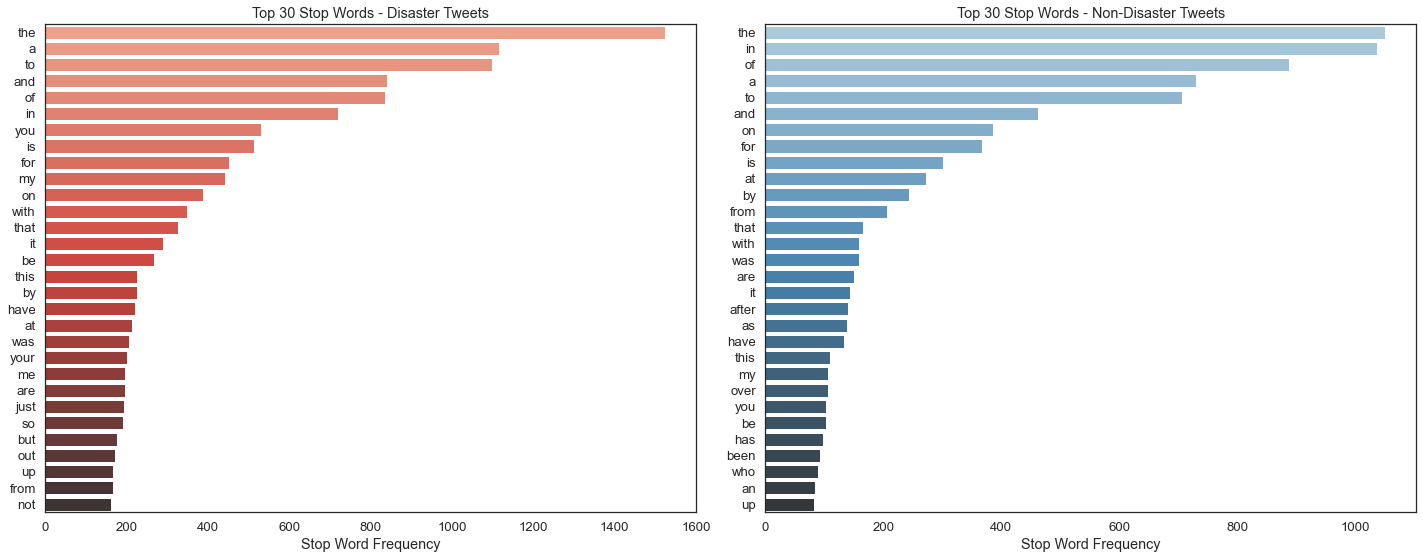

In [29]:
corpus_disaster_dict = create_corpus_dict(0)
corpus_non_disaster_dict = create_corpus_dict(1)

disaster_x, disaster_y = zip(*corpus_disaster_dict)
non_disaster_x, non_disaster_y = zip(*corpus_non_disaster_dict)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=list(disaster_x)[0:30], x=list(disaster_y)[0:30], orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(y=list(non_disaster_x)[0:30], x=list(non_disaster_y)[0:30], orient='h', palette="Blues_d", ax=ax[1]) 

ax[0].set_title("Top 30 Stop Words - Disaster Tweets")
ax[0].set_xlabel("Stop Word Frequency")
ax[1].set_title("Top 30 Stop Words - Non-Disaster Tweets")
ax[1].set_xlabel("Stop Word Frequency")
plt.tight_layout()
plt.show()

# Common non-stopwords

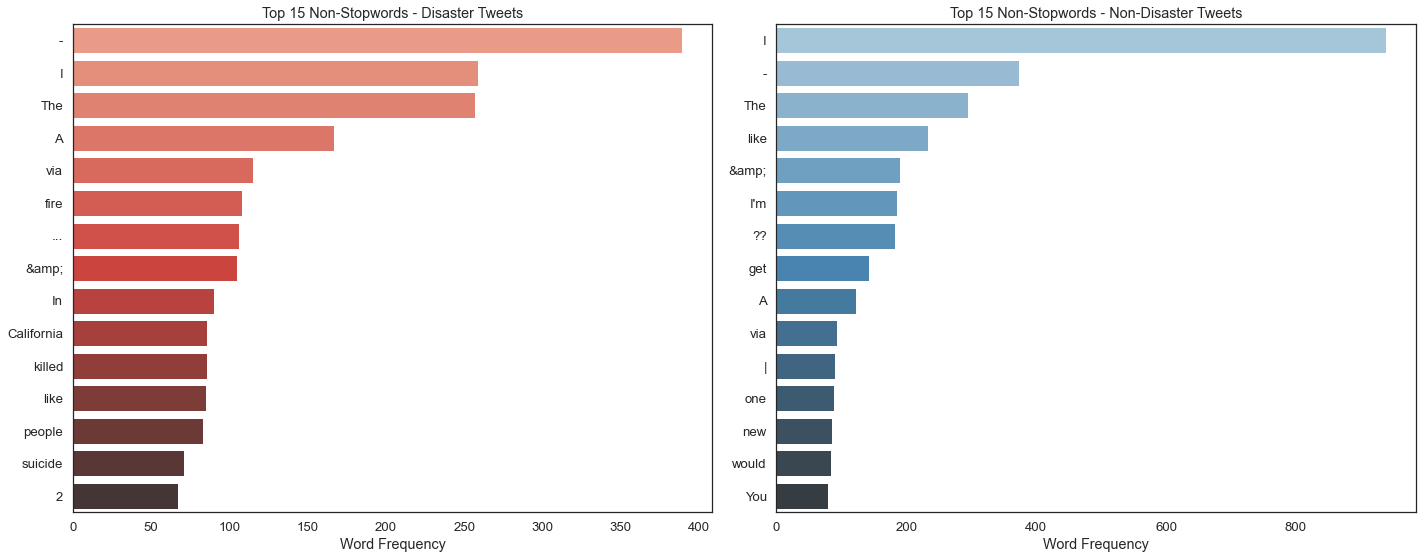

In [30]:
corpus_disaster, corpus_non_disaster = create_corpus(1), create_corpus(0)
counter_disaster, counter_non_disaster = Counter(corpus_disaster), Counter(corpus_non_disaster)
x_disaster, y_disaster, x_non_disaster, y_non_disaster = [], [], [], []

counter = 0
for word, count in counter_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_disaster.append(word)
        y_disaster.append(count)

counter = 0
for word, count in counter_non_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_non_disaster.append(word)
        y_non_disaster.append(count)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])
ax[0].set_title("Top 15 Non-Stopwords - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Non-Stopwords - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

# Common Bigrams

In [31]:
def bigrams(target):
    corpus = train[train["target"] == target]["text"]
    count_vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

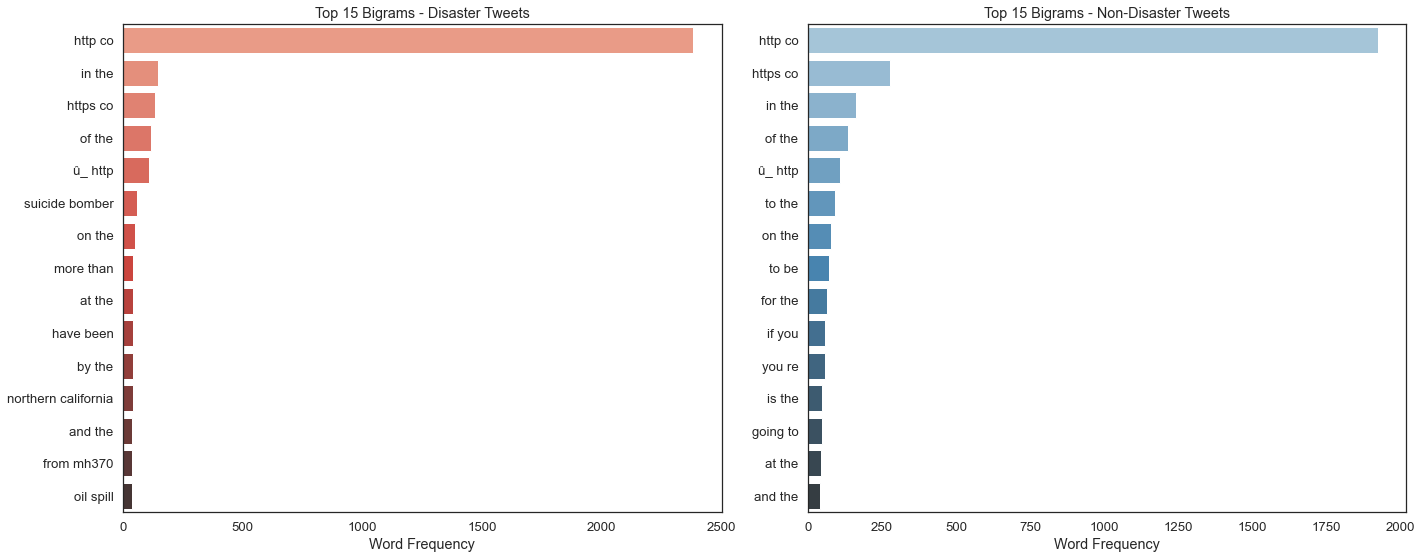

In [32]:
bigrams_disaster = bigrams(1)[:15]
bigrams_non_disaster = bigrams(0)[:15]

x_disaster, y_disaster = map(list, zip(*bigrams_disaster))
x_non_disaster, y_non_disaster = map(list, zip(*bigrams_non_disaster))

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])

ax[0].set_title("Top 15 Bigrams - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Bigrams - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

# Target distribution

Not Disaster: 57.03%, Disaster: 42.97%


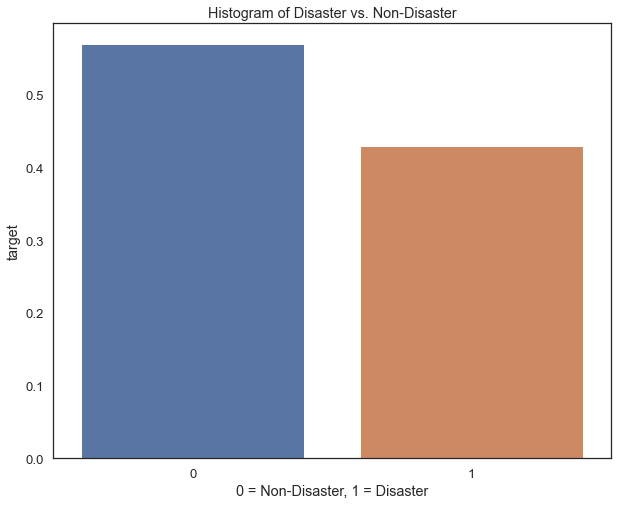

In [33]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

In [34]:
train

,id,keyword,location,text,target,tweet_length,num_words,avg_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,6.636364
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,20,5.300000
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8,7.250000
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,19,6.263158


In [35]:
from nltk.corpus import stopwords

#function for removing pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [36]:
# remove '#' handle
train['tweet'] = np.vectorize(remove_pattern)(train['text'], "#[\w]*")
test['tweet'] = np.vectorize(remove_pattern)(test['text'], "#[\w]*") 
train.head()

,id,keyword,location,text,target,tweet_length,num_words,avg_word_length,tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,Our Deeds are the Reason of this May ALLAH Fo...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,"13,000 people receive evacuation orders in Ca..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,Just got sent this photo from Ruby as smoke f...


In [37]:
#Delete everything except alphabet
train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")

test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")

train.head()

<ipython-input-37-3a7223a05d17>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")
<ipython-input-37-3a7223a05d17>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")


,id,keyword,location,text,target,tweet_length,num_words,avg_word_length,tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,Our Deeds are the Reason of this May ALLAH Fo...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,All residents asked to shelter in place are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,people receive evacuation orders in Ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,Just got sent this photo from Ruby as smoke f...


In [38]:
#Dropping words whose length is less than 3
train['tweet'] = train['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train.head()


,id,keyword,location,text,target,tweet_length,num_words,avg_word_length,tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,Deeds Reason this ALLAH Forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,Forest fire near Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,residents asked shelter place being notified o...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,people receive evacuation orders California
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,Just sent this photo from Ruby smoke from pour...


In [39]:
#convert all the words into lower case
train['tweet'] = train['tweet'].str.lower()

test['tweet'] = test['tweet'].str.lower()

In [40]:
set(stopwords.words('english'))

# set of stop words
stops = set(stopwords.words('english')) 

In [41]:
# tokens of words  
train['tokenized_sents'] = train.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)

test['tokenized_sents'] = test.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)


In [42]:
#function to remove stop words
def remove_stops(row):
    my_list = row['tokenized_sents']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

In [43]:
#removing stop words
train['clean_tweet'] = train.apply(remove_stops, axis=1)

test['clean_tweet'] = test.apply(remove_stops, axis=1)

train.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)
test.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)


In [44]:
#re-join the words after tokenization
def rejoin_words(row):
    my_list = row['clean_tweet']
    joined_words = ( " ".join(my_list))
    return joined_words



train['clean_tweet'] = train.apply(rejoin_words, axis=1)

test['clean_tweet'] = test.apply(rejoin_words, axis=1)

train.head()

,id,keyword,location,text,target,tweet_length,num_words,avg_word_length,clean_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,sent photo ruby smoke pours school


<b>Visual representation of all the words using word cloud

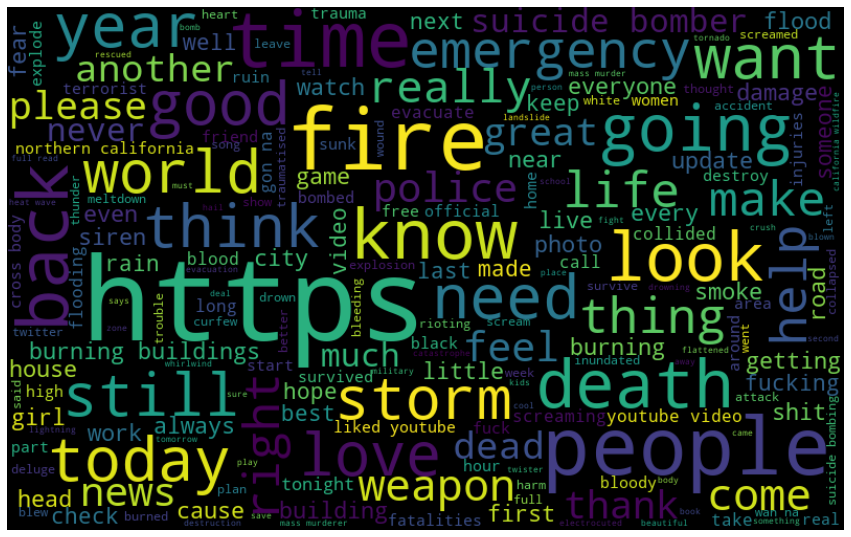

In [45]:
all_word = ' '.join([text for text in train['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(15, 12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

<b>Visual representation of all the words which signify real disaster using wordcloud

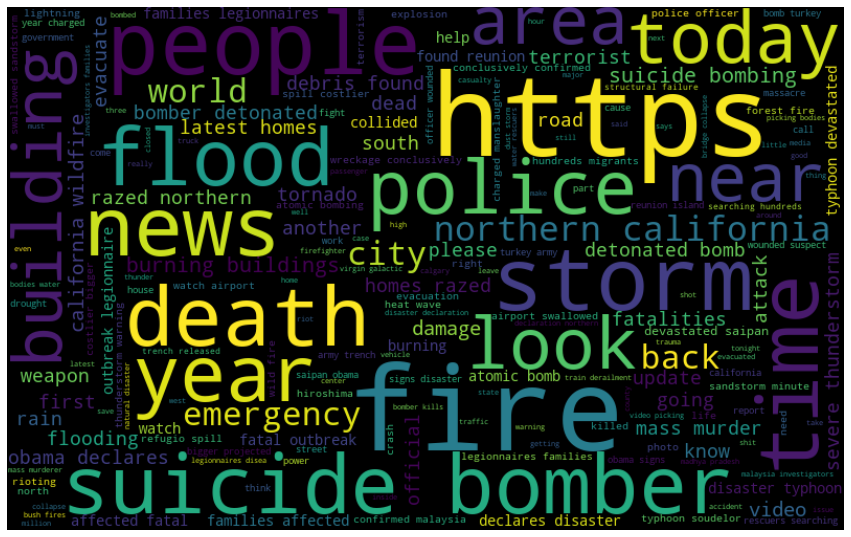

In [46]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 

plt.figure(figsize=(15, 12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<b>Visual representation of all the words which signify non-disaster using wordcloud
 

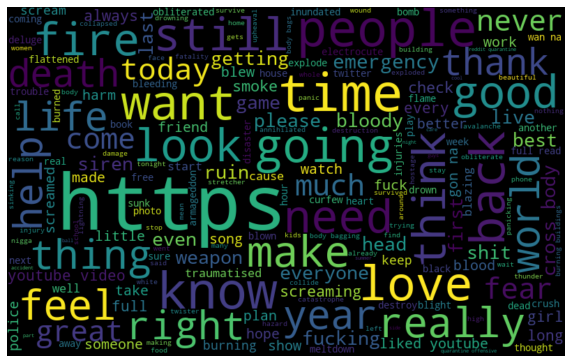

In [47]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<b>Load more necessary libraries

In [48]:
import gc
import time
import math
import random
import warnings

In [49]:
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [50]:
import string
import folium
from colorama import Fore, Back, Style, init


In [51]:
import scipy as sp
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
#from keras.utils import model_to_dot

import requests
from IPython.display import HTML

In [52]:
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

In [53]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

In [54]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger


In [55]:
#Tf 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

In [56]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

In [57]:
from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer
from sklearn.model_selection import train_test_split

#Sklearn models-Machine Learning classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


In [58]:
#Natural language processing library
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob


from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize


In [59]:
stopword=set(STOPWORDS) #stopword
lem = WordNetLemmatizer() #lemmatization 
tokenizer=TweetTokenizer() #tokenization
np.random.seed(0)
random_state = 42

In [60]:
#!pip install GPUtil


In [61]:
from torch import nn
from transformers import AdamW, BertConfig, BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

In [62]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

In [63]:
from torch import nn
from transformers import AdamW, BertConfig, BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

In [65]:
train = pd.read_csv("train.csv").loc[:,["text","target"]]
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [66]:
# select device
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

# **Data Preprocessing**

In [67]:
dupli_sum = train.duplicated().sum()
if(dupli_sum>0):
    print(dupli_sum, " duplicates found\nremoving...")
    train = train.loc[False==train.duplicated(), :]
else:
    print("no duplicates found")
train

92  duplicates found
removing...


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


In [68]:
X_train = train["text"].values
y_train = train["target"].values

In [69]:
X_train

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje',
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [70]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

BERT depends on a special tokenizing format & vocabulary. Thus, we need to use its custom tokenizer.

We should take a look at the resulting number of tokens that we would get by using the tokenizer without padding/truncating the sequences. Based on that we can define our padding/truncating-strategy.

In [71]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

lens = []

for text in X_train:
    encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    lens.append(encoded_dict['input_ids'].size()[1])

https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /Users/ajhvrry/.cache/huggingface/transformers/tmp6n84iv3n


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt in cache at /Users/ajhvrry/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /Users/ajhvrry/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /Users/ajhvrry/.cache/huggingface/transformers/tmp9er1p0f3


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json in cache at /Users/ajhvrry/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /Users/ajhvrry/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /Users/ajhvrry/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at /Users/ajhvrry/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
creating metadata file for /Users/ajhvrry/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/ajhvrry/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidd

text length mean:  33.09626379470815
text length median:  33.0
text length standard deviation:  12.145367271204988
suitable sequence length:  57.38699833711813


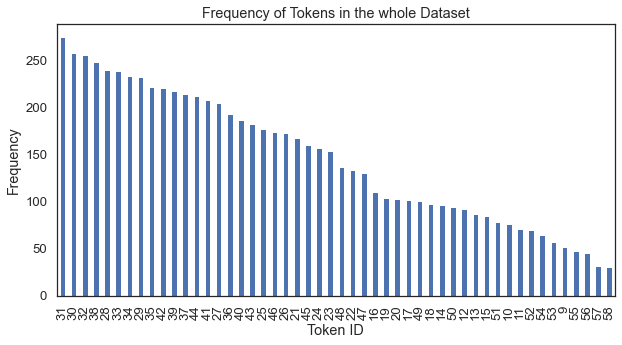

In [72]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Frequency of Tokens in the whole Dataset")
ax.set_xlabel("Token ID")
ax.set_ylabel("Frequency")


pd.Series(lens).value_counts().head(50).plot(kind="bar");

print("text length mean: ", np.array(lens).mean())
print("text length median: ", np.median(lens))
print("text length standard deviation: ", np.array(lens).std())
print("suitable sequence length: ", np.array(lens).mean() + 2*np.array(lens).std())

**Findings**:

no huge difference between mean and median
truncate the texts to a tokenized length of  
⌈
  mean + 2  ⋅ std  ⌉
  many tokens for more generalization  
→
  sequence_lengthsequence_length = 58

In [73]:
sequence_length = 58
# X_train_tokens[i] := sequence of sequence_length many tokens that represent text_{i}
X_train_tokens = []

for text in X_train:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True, # special tokens for BERT
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt', # pytorch tensor format
                                         truncation=True)
    X_train_tokens.append(encoded_dict['input_ids'])

In [74]:
# pytorch expects tensors
X_train_tokens = torch.cat(X_train_tokens, dim=0) # concat into one tensor

y_train = torch.tensor(y_train)

In [75]:
# tokenization of the first observation in the training set
# zero-padding is added
print('Original:\n', X_train[5])
print('Tokenization:\n', X_train_tokens[5])

Original:
 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Tokenization:
 tensor([  101,  1001,  6857, 10273, 10651,  1027,  1028,  2662,  1044, 18418,
         1012,  2322,  2701,  1999,  2119,  7826,  2349,  2000,  2697,  2221,
         2543,  1011,  1001, 24689,  7442,  1001,  3748, 26332,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])


In [76]:
batch_size = 32

# split into training and validation data
dataset = TensorDataset(X_train_tokens, y_train.float())

train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


train_dataloader = DataLoader(train_set, 
                              sampler=RandomSampler(train_set), 
                              batch_size=batch_size)

validation_dataloader = DataLoader(val_set, 
                                   sampler=RandomSampler(val_set), 
                                   batch_size=batch_size)

Let's take a look at what we get from our Dataloaders:

In [77]:
for batch in train_dataloader:
    print("what is drawn from our dataloader? ", type(batch))
    
    print("\nfirst entry: ", batch[0].size(), type(batch[0]), batch[0].dtype)
    print("\nsecond entry: ", batch[1].size(), type(batch[1]), batch[1].dtype)
    
    break

what is drawn from our dataloader?  <class 'list'>

first entry:  torch.Size([32, 58]) <class 'torch.Tensor'> torch.int64

second entry:  torch.Size([32]) <class 'torch.Tensor'> torch.float32


In [78]:
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device)

for batch in train_dataloader: 
    batch_features = batch[0].to(device)
    bert_output = bert(input_ids=batch_features) 
    
    print("bert output: ", type(bert_output), len(bert_output))
    
    print("first entry: ", type(bert_output[0]), bert_output[0].size())
    
    print("second entry: ", type(bert_output[1]), bert_output[1].size())
    
    break

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/ajhvrry/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin not found in cache or f

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /Users/ajhvrry/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /Users/ajhvrry/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /Users/ajhvrry/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq

bert output:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 2
first entry:  <class 'torch.Tensor'> torch.Size([32, 58, 768])
second entry:  <class 'torch.Tensor'> torch.Size([32, 768])


In [79]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased') # returns pwerful representations of the microblogs
        self.linear = nn.Linear(768, 1) # custom layer; input of the first custom layer has to match the dimensionality of the BERT-output; further custom layers are possible
        self.sigmoid = nn.Sigmoid() # activation function applied to our custom layer to obtain probabilities
    
    def forward(self, tokens):
        bert_output = self.bert(input_ids=tokens)
        linear_output = self.linear(bert_output[1])
        proba = self.sigmoid(linear_output)
        return proba

In [80]:
def eval(y_batch, probas):
    
    preds_batch_np = np.round(probas.cpu().detach().numpy())
    
    y_batch_np = y_batch.cpu().detach().numpy()
    
    acc = accuracy_score(y_true=y_batch_np, y_pred=preds_batch_np)
    
    f1 = f1_score(y_true=y_batch_np, y_pred=preds_batch_np, average='weighted')
    
    return acc, f1


In [81]:

def train(model, optimizer, scheduler, epochs, name):
    history = []
    best_f1 = 0
    model.train()
    
    for epoch in range(epochs):
        
        # ===== train =====
        print("=== Epoch: ", epoch+1, " / ", epochs, " ===")
        acc_total = 0
        f1_total = 0
        
        for it, batch in enumerate(train_dataloader): 
            
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)] # draw the batch
            
            probas = torch.flatten(model(tokens=x_batch))
            
            acc_f1_batch = eval(y_batch, probas)
            
            acc_total, f1_total = acc_total + acc_f1_batch[0], f1_total + acc_f1_batch[1]
            
            model.zero_grad() # reset the gradients
            
            loss_func = nn.BCELoss()
            
            batch_loss = loss_func(probas, y_batch)
            
            batch_loss.backward() # calculate gradient per (learnable) weight
            
            optimizer.step() # update (learnable) weights
            
            scheduler.step() # update learning rate
            
        acc_total = acc_total/len(train_dataloader) #len(train dataloader)=num_batches
        
        f1_total = f1_total/len(train_dataloader)
        
        print("accuracy: ", acc_total, "\nf1: ", f1_total)
        
        

        # ===== validate =====
        acc_val_total = 0
        f1_val_total = 0
        
        for batch in validation_dataloader:
            
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
            
            with torch.no_grad(): # gradients don't have to be computed, because no update is performed
                probas = torch.flatten(model(tokens=x_batch))
            acc_f1_val_batch = eval(y_batch, probas)
            
            acc_val_total, f1_val_total = acc_val_total + acc_f1_val_batch[0], f1_val_total + acc_f1_val_batch[1]
            
        acc_val_total = acc_val_total/len(validation_dataloader)
        f1_val_total = f1_val_total/len(validation_dataloader)
        
        print("validation accuracy: ", acc_val_total, "\nvalidation f1: ", f1_val_total, "\n")
        if(f1_val_total>best_f1): # save current mdoel if this epoch improved models validation performance 
            torch.save(model, name+".pt")
            best_f1 = f1_val_total

        history.append({"acc":acc_total, "f1":f1_total, "acc_val":acc_val_total, "f1_val":f1_val_total})
    return [torch.load(name+".pt"), history]

In [82]:
epochs = 10

baseline_bert_clf = BertClassifier()

baseline_bert_clf = baseline_bert_clf.to(device)

adam = AdamW(baseline_bert_clf.parameters(), lr=5e-5, eps=1e-8)

total_steps = len(train_dataloader) * epochs

sched = get_linear_schedule_with_warmup(adam, num_warmup_steps=0, num_training_steps=total_steps)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/ajhvrry/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin fr

In [83]:
baseline_bert_clf, history = train(model=baseline_bert_clf,
                                   optimizer=adam,
                                   scheduler=sched,
                                   epochs=10,
                                   name="baseline_bert_clf")

=== Epoch:  1  /  10  ===
accuracy:  0.7993683510638298 
f1:  0.7889397789795473
validation accuracy:  0.818359375 
validation f1:  0.8146213145270997 

=== Epoch:  2  /  10  ===
accuracy:  0.882313829787234 
f1:  0.8812154752829495
validation accuracy:  0.7981770833333334 
validation f1:  0.7980127588788078 

=== Epoch:  3  /  10  ===
accuracy:  0.9313497340425532 
f1:  0.9308521383420222
validation accuracy:  0.8229166666666666 
validation f1:  0.8215930694682666 

=== Epoch:  4  /  10  ===
accuracy:  0.9564494680851063 
f1:  0.9561040254424966
validation accuracy:  0.810546875 
validation f1:  0.810365730722646 

=== Epoch:  5  /  10  ===
accuracy:  0.9672539893617021 
f1:  0.9672100478744708
validation accuracy:  0.8079427083333334 
validation f1:  0.8067909010070297 

=== Epoch:  6  /  10  ===
accuracy:  0.9772273936170213 
f1:  0.9771961938490448
validation accuracy:  0.8125 
validation f1:  0.8103081212726461 

=== Epoch:  7  /  10  ===
accuracy:  0.9778922872340425 
f1:  0.9778

In [85]:
history_df = pd.DataFrame(history)

history_df

,acc,f1,acc_val,f1_val
0,0.799368,0.788940,0.818359,0.814621
1,0.882314,0.881215,0.798177,0.798013
2,0.931350,0.930852,0.822917,0.821593
3,0.956449,0.956104,0.810547,0.810366
4,0.967254,0.967210,0.807943,0.806791
5,0.977227,0.977196,0.812500,0.810308
6,0.977892,0.977865,0.810547,0.808428
7,0.981549,0.981427,0.784505,0.784588
8,0.982713,0.982726,0.809896,0.807579
9,0.986370,0.986351,0.805990,0.804093


In [86]:
# analogously to above:
X_test = pd.read_csv("test.csv")["text"]

X_test_tokens = []

for text in X_test:
    
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt',
                                         truncation=True)
    
    X_test_tokens.append(encoded_dict['input_ids'])
    
    
    
X_test_tokens = torch.cat(X_test_tokens, dim=0)



test_set = TensorDataset(X_test_tokens)

test_dataloader = DataLoader(test_set, 
                             sampler=SequentialSampler(test_set), 
                             batch_size=batch_size)

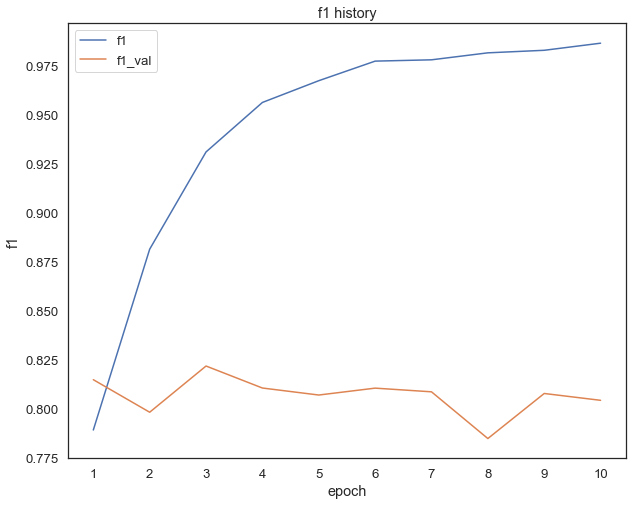

In [87]:
fig, ax = plt.subplots()
ax.set_title("f1 history")
ax.set_ylabel("f1")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0,20), labels=np.arange(1,21))
history_df.loc[:,['f1', 'f1_val']].plot(ax=ax)
plt.savefig("f1.png")


# Predict on Test

In [88]:
# analogously to above:
X_test = pd.read_csv("test.csv")["text"]

X_test_tokens = []
for text in X_test:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt',
                                         truncation=True)
    X_test_tokens.append(encoded_dict['input_ids'])
X_test_tokens = torch.cat(X_test_tokens, dim=0)



test_set = TensorDataset(X_test_tokens)
test_dataloader = DataLoader(test_set, 
                             sampler=SequentialSampler(test_set), 
                             batch_size=batch_size)

In [89]:
all_preds = []

for batch in test_dataloader:
    x_batch = batch[0].to(device)
    with torch.no_grad():
        probas = baseline_bert_clf(tokens=x_batch)
    preds = np.round(probas.cpu().detach().numpy()).astype(int).flatten()
    all_preds.extend(preds)